![data-x](https://raw.githubusercontent.com/afo/data-x-plaksha/master/imgsource/dx_logo.png)


# __Titanic Survivor Analysis__

#### Author: Several publc Kaggle Kernels
#### Edits: Alexander Fred Ojala, Kevin Li, and Elias Castro Hernandez

**Sources:** 
* **Training + explanations**: https://www.kaggle.com/c/titanic

___
___


<center><img src='https://static01.nyt.com/images/2018/10/24/travel/24xp-titanic-tear/24xp-titanic-tear-superJumbo.jpg' width=400px></center>

# Understanding the connections between passanger information and survival rate

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

<br>
The data conists of passanger information for the maiden, and tragic, voyage of the Titanic ocean liner. The set is comprised of 1309 unique entries, each associated with information realated to a passanger. The set is broken is broken down to 891/418 (testing/training) split for the purposes of modeling

**Our task is to train a machine learning model on the training set in order to predict if the passengers in the test set survived or not.**

<br>

### Table of Contents

> #### [Part 0: Install Additional Required Software](#Part-0:-Install-Additional-Required-Software)

> #### [Part 1: Import Packages + Libraries + Dependencies](#Part-1:-Import-Packages-+-Libraries-+-Dependencies)

> #### [Part 2: Preprocessing and Exploratory Data Anlysis](#Part-2:-Preprocessing-and-Exploratory-Data-Anlysis)

> #### [Part 3: Establishing a Hypothesis](#Part-3:-Establishing-a-Hypothesis)

> #### [Part 4: Machine Learning!](#Part-4:-Machine-Learning!)

### Additional Material

> #### [Appendix I: Why are our models maxing out at around 80%?](#Appendix-I:-Why-are-our-models-maxing-out-at-around-80%?)

> #### [Appendix II: Resources and references to material we won't cover in detail](#Appendix-II:-Resources-and-references-to-material-we-won't-cover-in-detail)

<br>

___
___

<a id='sec1'></a>

## Part 0: Install Additional Required Software

__Note:__To follow along with notebook, you will need to install the __xgboost__ package in your pyhton enviroment:

try (in terminal):
```
$ conda install py-xgboost
```

or 

try (directly in notebook)
```
!conda install py-xgboost --y
```

<a id='sec2'></a>
___
## Part 1: Import Packages + Libraries + Dependencies

### Import packages

In [19]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 7 machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

### Styling and fancy distribution plot

In [20]:
# Plot styling and display options
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 10 , 6

pd.set_option('display.max_columns', 100) # Print 100 Pandas columns

# Special distribution plot (will be used later)
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

### Load Data

In [21]:
!head data/train.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
combine = [train_df, test_df]
# combine is used to ensure whatever preprocessing is done on training data
# is also done on test data

# NOTE! When we change train_df or test_df the objects in combine 
# will also change (combine is only a pointer to the objects)

<a id='sec3'></a>
___
## Part 2: Exploring and Preprocessing the Data
**Data descriptions**

In [23]:
# Features/Variable names

train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [24]:
# preview the data

train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
# General data statistics

train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [26]:
# Data Frame information (null, data type etc)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Histograms

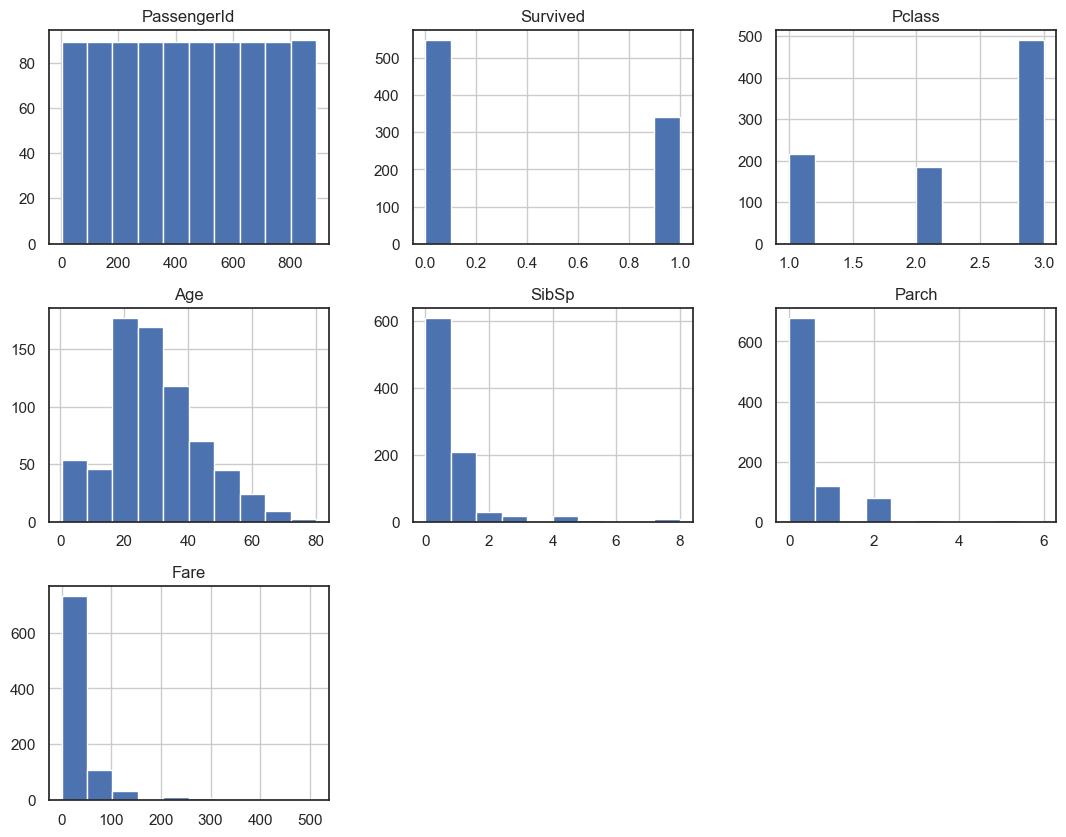

In [27]:
train_df.hist(figsize=(13,10))
plt.show()

### Insights into the data

In [28]:
train_df[['Pclass', 'Survived']].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


# Balanced data set?

In [29]:
# Balanced data set?

target_count = train_df['Survived'].value_counts()
target_count

0    549
1    342
Name: Survived, dtype: int64

__Note:__ If the goal is Prediction, unbalanced data introduce bias into model. 

Balanced data are good for classification, but you loose information such as appearance frequencies -- which may affect accuracy metrics themselves, as well as production performance.

In [30]:
# What is base line for prediction accuracy?

target_count[0]/(sum(target_count)) 

0.6161616161616161

___

> #### __Brief Remarks Regarding the Data__

> * `PassengerId` is a random number (incrementing index) and thus does not contain any valuable information. 

> * `Survived, Passenger Class, Age, Siblings Spouses, Parents Children` and `Fare` are numerical values (no need to transform them) -- but, we might want to group them (i.e. create categorical variables). 

> * `Sex, Embarked` are categorical features that we need to map to integer values. `Name, Ticket` and `Cabin` might also contain valuable information.

___

### Droping Redundant Data
__Note:__ It is important to remove variables that convey information already captured by some other variable. Doing so removes the correlation, while also diminishing potential overfit.

In [31]:
# Check dimensions of the train and test datasets

print("Shapes Before: (train) (test) = ", \
      train_df.shape, test_df.shape)

Shapes Before: (train) (test) =  (891, 12) (418, 11)


In [32]:
# Drop columns 'Ticket', 'Cabin', need to do it for both test and training

train_df = train_df.drop(['PassengerId','Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("Shapes After: (train) (test) =", train_df.shape, test_df.shape)

Shapes After: (train) (test) = (891, 9) (418, 9)


In [33]:
# Check if there are null values in the datasets

print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


### Data we have at hand to create ML models

In [34]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


<a id='sec4'></a>
____
## Part 3: Establishing Hypotheses

### _The Title of the person is a feature that can predict survival_

In [35]:
# List example titles in Name column

train_df.Name[:10]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [36]:
# from the Name column we will extract title of each passenger
# and save that in a column in the dataset called 'Title'
# if you want to match Titles or Names with any other expression
# refer to this tutorial on regex in python:
# https://www.tutorialspoint.com/python/python_reg_expressions.htm

# Create column called Title

for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.',\
                                                expand=False)

In [37]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [38]:
# Double check that our titles makes sense (by comparing to sex)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


>___
> #### __Jonkheer?__ 

> Most popular during medieval times, the title of _Jonkheer_ was given to a young and unmarried child of a high-ranking knight or nobleman -- __Considered the lowest rank of nobility.__

>___

In [39]:
# same but for test set
pd.crosstab(test_df['Title'], test_df['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [40]:
# We see common titles like Miss, Mrs, Mr, Master are dominant, we will
# correct some Titles to standard forms and replace the rarest titles 
# with single name 'Rare'

for dataset in combine:
    dataset['Title'] = dataset['Title'].\
                  replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',\
                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') #Mademoiselle
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') #Madame

In [41]:
# We now have more logical (contemporary) titles, and fewer groups

train_df[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


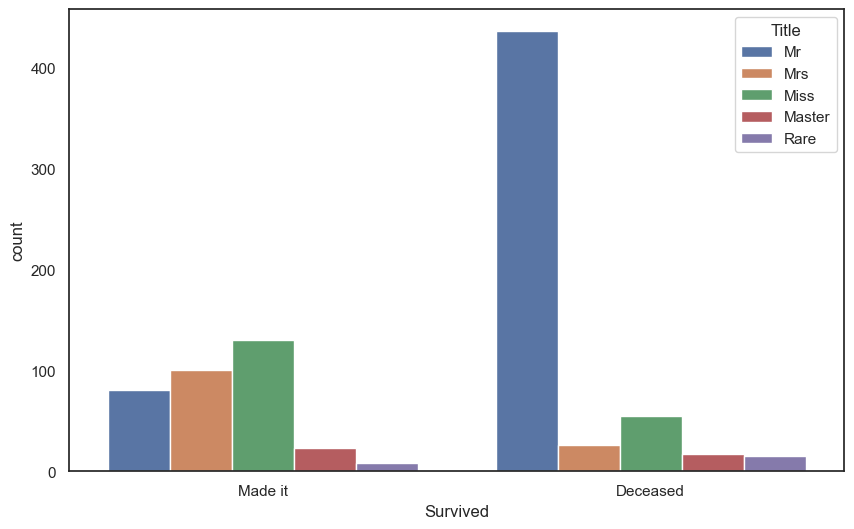

In [42]:
# We can plot the survival chance for each title

sns.countplot(x='Survived', hue="Title", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it','Deceased']);

In [43]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [44]:
# Title dummy mapping: Map titles to binary dummy columns

for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Title)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,0,0,1,0,0


In [45]:
# Remove unique variables for analysis (Title is generally bound to Name, so it's also dropped)

train_df = train_df.drop(['Name', 'Title'], axis=1)
test_df = test_df.drop(['Name', 'Title'], axis=1)
combine = [train_df, test_df]

In [46]:
# sanity check

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,male,22.0,1,0,7.2500,S,0,0,1,0,0
1,1,1,female,38.0,1,0,71.2833,C,0,0,0,1,0
2,1,3,female,26.0,0,0,7.9250,S,0,1,0,0,0
3,1,1,female,35.0,1,0,53.1000,S,0,0,0,1,0
4,0,3,male,35.0,0,0,8.0500,S,0,0,1,0,0


### Map Sex column to binary (male = 0, female = 1) categories

In [47]:
# convert categorical variable to numeric
for dataset in combine:
    dataset['Sex'] = dataset['Sex']. \
        map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22.0,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,38.0,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,26.0,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,35.0,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,35.0,0,0,8.0500,S,0,0,1,0,0


In [48]:
# Missing values for the age column
train_df['Age'].isnull().sum()

177

### Handle missing values for age
We will now guess values of age based on sex (male / female) 
and socioeconomic class (1st, 2nd, 3rd) of the passenger.

The row indicates the sex, male = 0, female = 1

> __IDEA:__ Wealth (indicated by class accomodation), as well as Gender, historically are indicative of age. 

> This approach gives us a more refined estimate than only taking the median / mean, etc. 

In [49]:
# create empty array  for later use

guess_ages = np.zeros((2,3),dtype=int) 
guess_ages

array([[0, 0, 0],
       [0, 0, 0]])

In [50]:
# Fill the NA's for the Age columns
# with "qualified guesses"

for idx,dataset in enumerate(combine):  
    # method adds a counter to an iterable and returns it in a form of enumerate object.     
    if idx==0:
        print('Working on Training Data set\n')
    else:
        print('-'*35)
        print('Working on Test Data set\n')
    
    print('Guess values of age based on sex and pclass of the passenger...')
    for i in range(0, 2):
        for j in range(0,3):
            guess_df = dataset[(dataset['Sex'] == i) \
                        & (dataset['Pclass'] == j+1)]['Age'].dropna()

            # Extract the median age for this group
            # (less sensitive) to outliers
            age_guess = guess_df.median()
          
            # Convert random age float to int
            guess_ages[i,j] = int(age_guess)
    
            
    print('Guess_Age table:\n',guess_ages)
    print ('\nAssigning age values to NAN age values in the dataset...')
    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) \
                    & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
                    

    dataset['Age'] = dataset['Age'].astype(int)
    print()
print('Done! \n\n\n')
train_df.head()

Working on Training Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[40 30 25]
 [35 28 21]]

Assigning age values to NAN age values in the dataset...

-----------------------------------
Working on Test Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[42 28 24]
 [41 24 22]]

Assigning age values to NAN age values in the dataset...

Done! 





,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,38,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,26,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,35,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,35,0,0,8.0500,S,0,0,1,0,0


### Split age into bands / categorical ranges and look at survival rates

In [51]:
# Age bands
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False)\
                    .mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


### Distribution of suvival relative to age

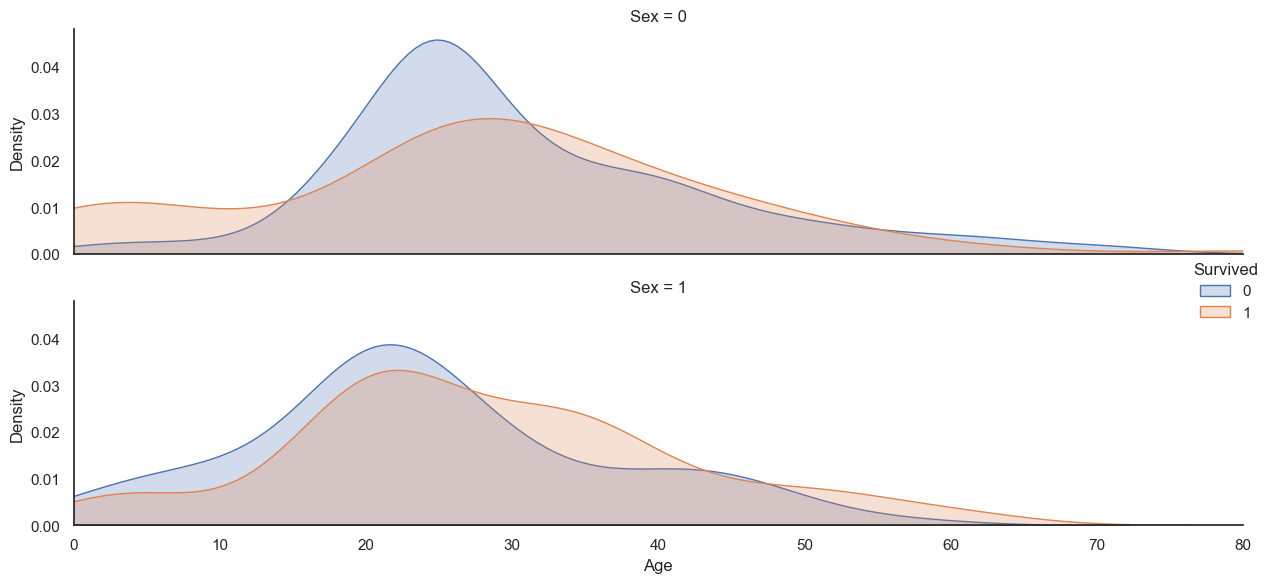

In [52]:
# Plot distributions of Age of passangers who survived 
# or did not survive

plot_distribution( train_df , var = 'Age' , target = 'Survived' ,\
                  row = 'Sex' )

# Recall: {'male': 0, 'female': 1}

In [53]:
# Change Age column to
# map Age ranges (AgeBands) to integer values of categorical type 

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 1
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 64, 'Age']=5
train_df.head()

# Note we could just run 
# dataset['Age'] = pd.cut(dataset['Age'], 5,labels=[1,2,3,4,5])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,AgeBand
0,0,3,0,2,1,0,7.2500,S,0,0,1,0,0,"(16.0, 32.0]"
1,1,1,1,3,1,0,71.2833,C,0,0,0,1,0,"(32.0, 48.0]"
2,1,3,1,2,0,0,7.9250,S,0,1,0,0,0,"(16.0, 32.0]"
3,1,1,1,3,1,0,53.1000,S,0,0,0,1,0,"(32.0, 48.0]"
4,0,3,0,3,0,0,8.0500,S,0,0,1,0,0,"(32.0, 48.0]"


In [54]:
# remove AgeBand column

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,2,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,3,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,2,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,3,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,3,0,0,8.0500,S,0,0,1,0,0


### Travel Party Size

How did the number of people the person traveled with impact the chance of survival?

In [55]:
# SibSp = Number of Sibling / Spouses
# Parch = Parents / Children

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    
# Survival chance against FamilySize

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True) \
                                .mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


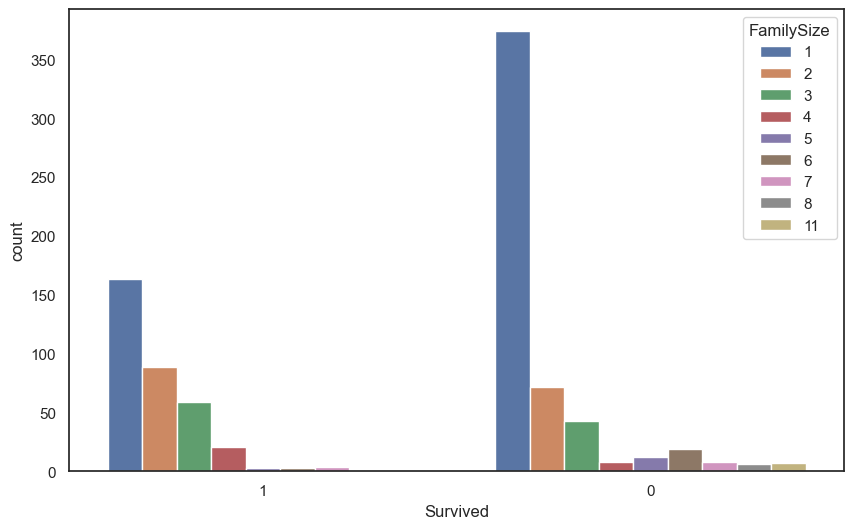

In [56]:
# Plot it, 1 is survived

sns.countplot(x='Survived', hue="FamilySize", data=train_df, order=[1,0]);

In [57]:
# Create binary variable if the person was alone or not

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=True).mean()

,Survived
IsAlone,
0,0.505650
1,0.303538


In [58]:
# We will only use the binary IsAlone feature for further analysis

for df in combine:
    df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1, inplace=True)


train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone
0,0,3,0,2,7.2500,S,0,0,1,0,0,0
1,1,1,1,3,71.2833,C,0,0,0,1,0,0
2,1,3,1,2,7.9250,S,0,1,0,0,0,1
3,1,1,1,3,53.1000,S,0,0,0,1,0,0
4,0,3,0,3,8.0500,S,0,0,1,0,0,1


# Feature construction

In [59]:
# We can also create new features based on intuitive combinations
# Here is an example when we say that the age times socioclass is a determinant factor

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head()

,Age*Class,Age,Pclass
0,6,2,3
1,3,3,1
2,6,2,3
3,3,3,1
4,9,3,3


In [60]:
train_df[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=True).mean()

,Survived
Age*Class,
1,0.888889
2,0.775000
3,0.526627
4,0.457143
5,0.166667
6,0.269430
8,0.352941
9,0.100000
10,0.000000


### Port the person embarked from
Let's see how that influences chance of survival

<img src= "data/images/titanic_voyage_map.png">
>___

> #### __Interesting Fact:__ 

> Third Class passengers were the first to board, with First and Second Class passengers following up to an hour before departure. 

> Third Class passengers were inspected for ailments and physical impairments that might lead to their being refused entry to the United States, while First Class passengers were personally greeted by Captain Smith.

In [61]:
# To replace Nan value in 'Embarked', we will use the mode
# in 'Embaraked'. This will give us the most frequent port 
# the passengers embarked from

freq_port = train_df['Embarked'].dropna().mode()[0]
print('Most frequent port of Embarkation:',freq_port)


Most frequent port of Embarkation: S


In [62]:
# Fill NaN 'Embarked' Values in the datasets

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

### Survival relative to port of origin

In [63]:
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True) \
                    .mean().sort_values(by='Survived', ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


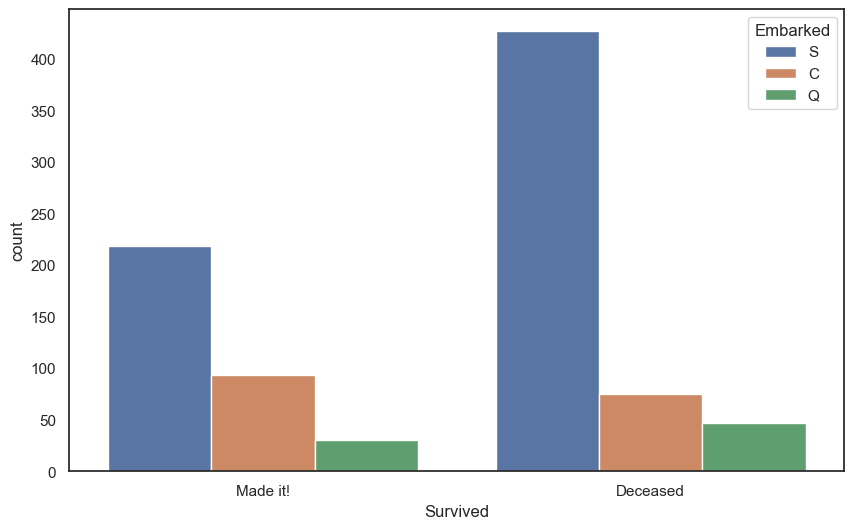

In [64]:
# Plot of relationship between survival and origin 

sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it!', 'Deceased']);


In [65]:
# Create categorical dummy variables for Embarked values

for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Embarked)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

    
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,2,7.2500,S,0,0,1,0,0,0,6,0,0,1
1,1,1,1,3,71.2833,C,0,0,0,1,0,0,3,1,0,0
2,1,3,1,2,7.9250,S,0,1,0,0,0,1,6,0,0,1
3,1,1,1,3,53.1000,S,0,0,0,1,0,0,3,0,0,1
4,0,3,0,3,8.0500,S,0,0,1,0,0,1,9,0,0,1


In [66]:
# Drop Embarked

for dataset in combine:
    dataset.drop('Embarked', axis=1, inplace=True)

### Fare Amount
What is the relationship between _Fare_ and survival

In [67]:
test_df['Fare'].isnull().sum()

1

In [68]:
# Fill the NA values in the Fares column with the median

test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,892,3,0,3,7.8292,0,0,1,0,0,1,9,0,1,0
1,893,3,1,3,7.0000,0,0,0,1,0,0,9,0,0,1
2,894,2,0,4,9.6875,0,0,1,0,0,1,8,0,1,0
3,895,3,0,2,8.6625,0,0,1,0,0,1,6,0,0,1
4,896,3,1,2,12.2875,0,0,0,1,0,0,6,0,0,1


<AxesSubplot:>

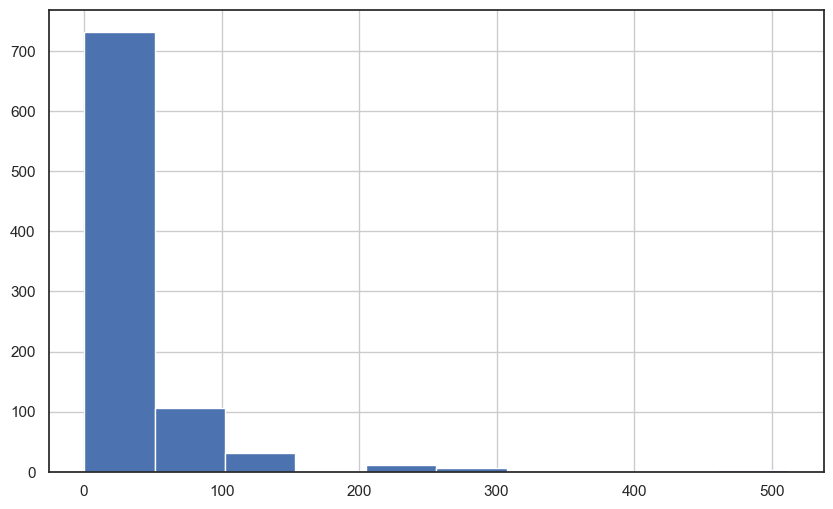

In [69]:
train_df['Fare'].hist()

In [70]:
# q cut will find ranges equal to the quartile of the data

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [71]:
# Create categorical values for the models to generalize

for dataset in combine:
    dataset['Fare']=pd.qcut(train_df['Fare'],4,labels=np.arange(4))
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df[['Fare','FareBand']].head()

,Fare,FareBand
0,0,"(-0.001, 7.91]"
1,3,"(31.0, 512.329]"
2,1,"(7.91, 14.454]"
3,3,"(31.0, 512.329]"
4,1,"(7.91, 14.454]"


In [72]:
# Drop FareBand

train_df = train_df.drop(['FareBand'], axis=1) 
combine = [train_df, test_df]

### Finished -- Preprocessing Complete!

In [73]:
# All features are approximately on the same scale
# no need for feature engineering / normalization

train_df.head(7)

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,2,0,0,0,1,0,0,0,6,0,0,1
1,1,1,1,3,3,0,0,0,1,0,0,3,1,0,0
2,1,3,1,2,1,0,1,0,0,0,1,6,0,0,1
3,1,1,1,3,3,0,0,0,1,0,0,3,0,0,1
4,0,3,0,3,1,0,0,1,0,0,1,9,0,0,1
5,0,3,0,2,1,0,0,1,0,0,1,6,0,1,0
6,0,1,0,4,3,0,0,1,0,0,1,4,0,0,1


In [74]:
test_df.head(7)

,PassengerId,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,892,3,0,3,0,0,0,1,0,0,1,9,0,1,0
1,893,3,1,3,3,0,0,0,1,0,0,9,0,0,1
2,894,2,0,4,1,0,0,1,0,0,1,8,0,1,0
3,895,3,0,2,3,0,0,1,0,0,1,6,0,0,1
4,896,3,1,2,1,0,0,0,1,0,0,6,0,0,1
5,897,3,0,1,1,0,0,1,0,0,1,3,0,0,1
6,898,3,1,2,3,0,1,0,0,0,1,6,0,1,0


### Sanity Check: View the correlation between features in our processed dataset

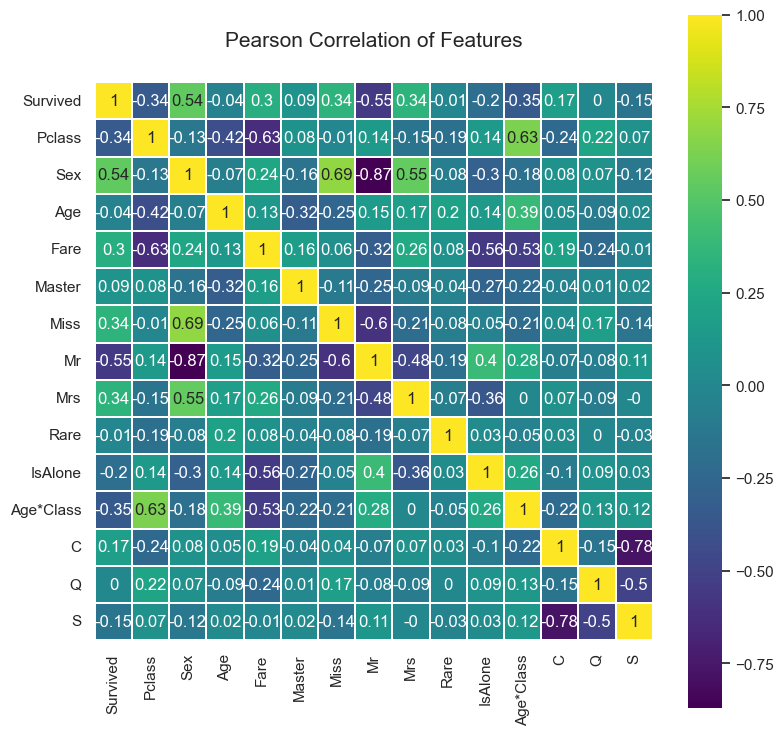

In [75]:
# Uncorrelated features are generally more powerful predictors

colormap = plt.cm.viridis
plt.figure(figsize=(9,9))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

<a id='sec5'></a>
___
## Part 4: Machine Learning!
Now we will Model, Predict, and Choose from algorithms for classification. 
We will try using different classifiers to model and predict. 

We ultimately will choose the best model from:
1. Logistic Regression
2. K-Nearest Neighbors (KNN) 
3. Support Vector Machines (SVM)
4. Perceptron
5. XGBoost
6. Random Forest
7. Dense Neural Network

### Setup Training and Validation Sets

In [76]:
X = train_df.drop("Survived", axis=1) # Training & Validation data
Y = train_df["Survived"]              # Response / Target Variable

X_submission  = test_df.drop("PassengerId", axis=1).copy()

print(X.shape, Y.shape)

(891, 14) (891,)


In [77]:
# Split training set so that we validate on 20% of the data
# Note that our algorithms will never have seen the validation 
# data during training. This is to evaluate how good our estimators are.

np.random.seed(42) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(712, 14) (712,)
(179, 14) (179,)


___
> ### Scikit-Learn general ML workflow
> 1. __Instantiate__ model object
> 2. __Fit__ model to training data
> 3. __Predict & Evaluate__ predict output for data not used during training and compare predicitons against true output values to form an accuracy measure.

___

### Comparing Modeling Approaches (Algorithms)

#### 1. Logistic Regression

In [78]:
logreg = LogisticRegression()                                # instantiate
logreg.fit(X_train, Y_train)                                 # fit
Y_pred = logreg.predict(X_val)                               # predict
acc_logreg = sum(Y_pred == Y_val)/len(Y_val)*100                # evaluate

print('Logistic Regression labeling accuracy:', str(round(acc_logreg,2)),'%')

Logistic Regression labeling accuracy: 78.77 %


In [79]:
# we could also use scikit learn's method score
# that predicts and then compares to validation set labels
acc_log_2 = logreg.score(X_val, Y_val)                       # evaluate

print('Logistic Regression using built-in method:', str(round(acc_log_2*100,2)),'%')

Logistic Regression using built-in method: 78.77 %


#### 2. KNN

In [80]:
knn = KNeighborsClassifier(n_neighbors = 5)                  # instantiate
knn.fit(X_train, Y_train)                                    # fit
acc_knn = knn.score(X_val, Y_val)                            # predict + evaluate

print('K-Nearest Neighbors labeling accuracy:', str(round(acc_knn*100,2)),'%')                                

K-Nearest Neighbors labeling accuracy: 80.45 %


#### 3. SVM

In [81]:
# Support Vector Machines Classifier (non-linear kernel)
svc = SVC()                                                  # instantiate
svc.fit(X_train, Y_train)                                    # fit
acc_svc = svc.score(X_val, Y_val)                            # predict + evaluate

print('Support Vector Machines labeling accuracy:', str(round(acc_svc*100,2)),'%')

Support Vector Machines labeling accuracy: 79.33 %


In [82]:
svc = SVC(C=2)                                                # instantiate
svc.fit(X_train, Y_train)                                    # fit
acc_svc = svc.score(X_val, Y_val)                            # predict + evaluate

print('Support Vector Machines labeling accuracy:', str(round(acc_svc*100,2)),'%')

Support Vector Machines labeling accuracy: 81.01 %


In [83]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

params = {'C':[0.01,0.1,1,10],
'kernel': ['linear','poly','rbf'],
'gamma':['auto', 'scale']}

gs_svm = GridSearchCV(SVC(), param_grid=params, cv=5, verbose=1)
gs_svm.fit(X_train, Y_train)
gs_svm.score(X_val, Y_val)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


0.8044692737430168

In [140]:
gs_svm.best_estimator_.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))
output_svm = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': gs_svm.best_estimator_.predict(test_df.drop('PassengerId',axis=1)).astype(np.int_)})
output_svm.to_csv('res_svm1.csv', index=False)

In [84]:
output_svm = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': svc.predict(test_df.drop('PassengerId', axis=1)).astype(np.int_)})
output_svm.to_csv('res_svm.csv', index=False)

#### 4. Perceptron

In [85]:
perceptron = Perceptron()                                    # instantiate 
perceptron.fit(X_train, Y_train)                             # fit
acc_perceptron = perceptron.score(X_val, Y_val)              # predict + evalaute

print('Perceptron labeling accuracy:', str(round(acc_perceptron*100,2)),'%')

Perceptron labeling accuracy: 75.98 %


#### 5. XGBoost

In [86]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from xgboost import XGBClassifier
params = { 'max_depth': [10,25,30],
           'learning_rate': [0.01, 0.1, 1],
           'subsample': np.linspace(0,1,10),
           'colsample_bytree': np.linspace(0,1,5),
           'colsample_bylevel': np.linspace(0,1,5),
          'min_child_weight':[10, 20, 30],
         'gamma':np.linspace(0, 0.1, 10),
          'n_estimators': [300, 500, 700, 900],
         }
gs_xgb = RandomizedSearchCV(XGBClassifier(), param_distributions=params, cv=5, verbose=1)
gs_xgb.fit(X_train, Y_train)
gs_xgb.score(X_val, Y_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.776536312849162

In [130]:
gs_xgb.best_params_

{'subsample': 1.0,
 'n_estimators': 500,
 'min_child_weight': 10,
 'max_depth': 30,
 'learning_rate': 0.1,
 'gamma': 0.03333333333333333,
 'colsample_bytree': 0.25,
 'colsample_bylevel': 0.75}

In [133]:
gs_xgb.best_estimator_.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))
output_xgb = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': gs_xgb.best_estimator_.predict(test_df.drop('PassengerId',axis=1)).astype(np.int_)})
output_xgb.to_csv('res_xgb1.csv', index=False)

In [116]:
pd.DataFrame({'col_names': X_val.drop(['Age*Class', 'IsAlone'], axis=1).columns,'Importance': gradboost.feature_importances_}).sort_values(by='Importance')

,col_names,Importance
2,Age,0.013684
9,C,0.013692
7,Mrs,0.014635
10,Q,0.016616
3,Fare,0.028504
11,S,0.031151
5,Miss,0.033339
4,Master,0.042367
0,Pclass,0.101656
1,Sex,0.188541


In [118]:
output_xgb = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': gradboost.predict(test_df.drop(['PassengerId', 'Age*Class', 'IsAlone'], axis=1)).astype(np.int_)})
output_xgb.to_csv('res_xgb.csv', index=False)

#### 6. Random Forest

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=500)   # instantiate
random_forest.fit(X_train, Y_train)                         # fit
acc_rf = random_forest.score(X_val, Y_val)                  # predict + evaluate

print('K-Nearest Neighbors labeling accuracy:', str(round(acc_rf*100,2)),'%')

In [90]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

params = {'n_estimators':[20,40,60,80,100,200,400,600,800],
'criterion': ['gini','entropy','log_loss'],
'max_depth':[1,3,5,7,9]}

gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, verbose=1)
gs_rf.fit(X_train, Y_train)
gs_rf.score(X_val, Y_val)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


0.7932960893854749

In [89]:
gs_rf.best_estimator_.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))
output_rf = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': gs_xgb.best_estimator_.predict(test_df.drop('PassengerId',axis=1)).astype(np.int_)})
output_rf.to_csv('res_rf.csv', index=False)

## Dense Neural Network

In [ ]:
train_df.shape

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# instantiate

model = Sequential()
model.add( Dense(units=300, activation='relu', input_shape=(14,) ))
model.add( Dense(units=100, activation='relu'))
model.add( Dense(units=50, activation='relu'))
model.add( Dense(units=1, activation='sigmoid') )

In [ ]:
# fit

model.compile(loss = 'binary_crossentropy', optimizer = 'adam',\
              metrics = ['accuracy'])
model.fit(X_train.values, Y_train.values, epochs = 50, batch_size= 50)

In [ ]:
# Evaluate the model Accuracy on test set
print('Neural Network accuracy:',str(round(model.evaluate(X_val.values, \
                Y_val.values, batch_size=50,verbose=False)[1]*100,2)),'%')

In [ ]:
train_df.head()

### Importance scores in the random forest model

In [ ]:
# Look at importnace of features for random forest

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ('Training accuracy Random Forest:',model.score( X , y ))

plot_model_var_imp(random_forest, X_train, Y_train)

# Ensembling

In [ ]:
from sklearn.ensemble import VotingClassifier

# Define the classifiers
rf = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(probability=True)

# Define the ensemble model
ensemble = VotingClassifier(estimators=[('rf', rf), ('knn', knn), ('svm', svm)], voting='soft')

# Fit the ensemble model to the data
ensemble.fit(X_train, Y_train)

# Predict the labels of the test set
y_pred = ensemble.predict(X_val)

# Evaluation
acc = accuracy_score(Y_val, y_pred)

print("Accuracy: ", acc)

# Optimizing & evaluating a classifier

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid
param_grid = {'n_estimators': [250, 500, 750],
              'max_depth': [10, 20],
              'min_samples_split': [2, 10],
              'min_samples_leaf': [1, 2, 4]}

# Create the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train);

In [146]:
# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict the labels of the val set
y_pred = best_model.predict(X_val)

# Evaluation
acc = accuracy_score(Y_val, y_pred)
prec = precision_score(Y_val, y_pred)
recall = recall_score(Y_val, y_pred)
f1 = f1_score(Y_val, y_pred)

print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", recall)
print("F1-score: ", f1)

Best parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}
Accuracy:  0.7932960893854749
Precision:  0.7761194029850746
Recall:  0.7027027027027027
F1-score:  0.7375886524822697


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_val, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(Y_val, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compete on Kaggle!

In [ ]:
# How to create a Kaggle submission with a Random Forest Classifier
Y_submission = best_model.predict(X_submission)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_submission
    })
submission.to_csv('titanic.csv', index=False)

In [ ]:
train_df.head()

<a id='sec6'></a>
___
___

## Appendix I: Why are our models maxing out at around 82%?


#### __John Jacob Astor__

<img src= "data/images/john-jacob-astor.jpg"> 

John Jacob Astor perished in the disaster even though our model predicted he would survive. Astor was the wealthiest person on the Titanic -- his ticket fare was valued at over 35,000 USD in 2016 -- it seems likely that he would have been among of the approximatelly 35 percent of men in first class to survive. However, this was not the case: although his pregnant wife survived, John Jacob Astor’s body was recovered a week later, along with a gold watch, a diamond ring with three stones, and no less than 92,481 USD (2016 value) in cash.

<br >


#### __Olaus Jorgensen Abelseth__

<img src= "data/images/olaus-jorgensen-abelseth.jpg">

Abelseth was a 25-year-old Norwegian sailor, a man in 3rd class, and not expected to survive by classifier. However, once the ship sank, he survived by swimming for 20 minutes in the frigid North Atlantic water before joining other survivors on a waterlogged collapsible boat.

Abelseth got married three years later, settled down as a farmer in North Dakota, had 4 kids, and died in 1980 at the age of 94.

<br >

### __Key Takeaway__ 

As engineers and busines professionals, we are trained to as ourselves, what could we do to improve on an 80 percent average. As it is often the case, it’s easy to forget that these data points represent real people. Each time our model was wrong we should be glad -- in such misclasifications we will likely find incredible stories of human nature and courage triumphing over extremely difficult odds. 

__It is important to never lose sight of the human element when analyzing data that deals with people.__ 

<a id='sec7'></a>
___
## Appendix II: Resources and references to material we won't cover in detail

> * **Gradient Boosting:** http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

> * **Jupyter Notebook (tutorial):** https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook

> * **K-Nearest Neighbors (KNN):** https://towardsdatascience.com/introduction-to-k-nearest-neighbors-3b534bb11d26

> * **Logistic Regression:** https://towardsdatascience.com/5-reasons-logistic-regression-should-be-the-first-thing-you-learn-when-become-a-data-scientist-fcaae46605c4

> * **Naive Bayes:** http://scikit-learn.org/stable/modules/naive_bayes.html

> * **Perceptron:** http://aass.oru.se/~lilien/ml/seminars/2007_02_01b-Janecek-Perceptron.pdf

> * **Random Forest:** https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d

> * **Support Vector Machines (SVM):** https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989


<br>
___
___

![](https://raw.githubusercontent.com/afo/data-x-plaksha/master/imgsource/dx_logo.png)